# Practice 5: Ligand-based detection: machine learning

## Theory

<img src="./img/ML_overview.png" width="200" align='right'>

To apply ML successfully, we need a large dataset of molecules, a molecular coding (fingerprinting), a label per molecule in the dataset (inactive: 0, active: 1), and an ML algorithm to train a model. . So, we can make predictions for new molecules.

### Machine Learning (AA)

ML can be requested (see also [scikit-learn page](http://scikit-learn.org/stable/)):

In this lab we work on a **Classification (supervised)**: identify to which category an object belongs, using a **Random Forest** classification model (Multiple decision trees that produce an average prediction).
<img src="./img/RF_example.png" width="200" align='right'>

### Validation Strategy: K-fold Cross Validation

* This model validation technique divides the data set into two groups iteratively:
     * Training data set: Considered as the known data set on which the model is trained
     * Test data set: unknown data set on which the model is then tested
     * The process is repeated k times

* The goal is to test the model's ability to predict data that has never been seen before, to detect problems known as overfitting, and to assess the generalizability of the model.

### Performance Measures
<img src="./img/FP_TP_fig.png" width="250" align='right'>

* **Sensitivity**, also true positive rate: TPR = TP/(FN+TP)
* **Specificity**, also true negative rate: TNR = TN/(FP + TN)
* **Precision**, also trueness: ACC = (TP + TN)/(TP + TN + FP + FN)
* **ROC curve**, receiver operating characteristic curve
     * A graphical diagram illustrating the diagnostic capabilities of our classifier
     * Plots sensitivity vs. specificity.
* **AUC**, the area under the rock curve (AUC):
     * Describes the probability that a classifier will rank a randomly chosen positive instance higher than a negative one
     * Values between 0 and 1, the higher the better

# Data preparation
Starting by importing the data from the previous practice, as it is stored in a different folder, the first thing we have to do is create a `root directory` (`ROOT_DIR`) to be able to navigate to the file
## Data loading

In [26]:
# Libraries needed to import the saved database
import pandas as pd
import os
from pathlib import Path

current_directory = os.getcwd()
ROOT_DIR = Path(current_directory).parent
uniprot_id = 'P49841'
print('Root directory:', ROOT_DIR)
df_output = pd.read_csv(f'{ROOT_DIR}/2_PART_TWO/data/compounds_P49841_lipinski.csv')
df_output.head()

Root directory: /home/emocha/Desktop/UdeC/Proyecto_ML/DS-for-DD-main


,molecule_chembl_id,pchembl_value,smiles,ROMol,MW,HBA,HBD,LogP,rule_of_five_conform
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,514.165248,6,1,3.3616,yes
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,407.186987,7,3,2.4397,yes
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,392.196074,8,0,1.9610,yes
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,484.211055,7,1,3.2107,yes
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...,<rdkit.Chem.rdchem.Mol object at 0x000001E1423...,392.196074,8,0,1.9610,yes


In this practice we only need the ligands that comply with the *rule of five*, therefore, we must filter by the column: `rule_of_five_conform:yes`. Also, we only need the first three columns

In [27]:
print(f'# total links: {len(df_output)}')
df_output = df_output[df_output['rule_of_five_conform']=='yes']
df_output = df_output[['molecule_chembl_id', 'pchembl_value', 'smiles']]
print(f'# filtered ligands (rule_of_five_conform:yes): {len(df_output)}')

df_output.head()

# total links: 2657
# filtered ligands (rule_of_five_conform:yes): 2477


,molecule_chembl_id,pchembl_value,smiles
0,CHEMBL2386094,10.89,O=C1NC(=O)C(c2cn3c4c(cc(F)cc24)CN(C(=O)N2CCOCC...
1,CHEMBL3895998,10.00,Nc1ncc(-c2ccccc2F)nc1C(=O)Nc1cnccc1N1CCC(N)CC1
2,CHEMBL4084855,10.00,COc1ccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](C...
3,CHEMBL564450,9.85,COc1cc(C2=C(c3cn(CCN4CCN(C)CC4)c4ccccc34)C(=O)...
4,CHEMBL4063206,9.70,COc1cccc(N2CCN(c3nc(-c4ccncn4)cc(=O)n3C)[C@H](...


## Data processing
### Fingerprints
To train the algorithm, we need to convert the ligands to a list of features. At this moment we have the molecular structure (smile) of each ligand, with this information we can import the *fingerprint* and use this new representation to train the model.

To find and import the fingerprints of each ligand, the `rdkit` library is used, creating a new column in the dataset with the fingerprint. There are several types of fingerprint, for now we are going to work with [Extended Connectivity Fingerprint ECFP](https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md) also known as morgan2_c/ecfp4

In [28]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
df_fp = df_output.copy()
df_fp['morgan2_c'] = df_output.smiles.map(lambda smile: rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2).ToList())
df_fp = df_fp[['molecule_chembl_id', 'morgan2_c', 'pchembl_value']]
df_fp.head()

,molecule_chembl_id,morgan2_c,pchembl_value
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85
4,CHEMBL4063206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70


Let's explore the first fingerprint: it is a binary list (ones and zeros) with a length of 2048 elements. These fingerprint elements will be the features that will be used to train the model.

In [29]:
print(df_fp.morgan2_c[0])
print(len(df_fp.morgan2_c[0]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Classification of ligands
Each ligand must be classified as **active** or **inactive**, for this we will use the `pIC50` column defining activity thresholds
The protein *Glycogen synthase kinase-3 beta* is classified in the group of *Kinases*, therefore, we will use the following thresholds:
**Inactive**: *pchem_value* < 6.52 uM
**Active**: **pchem_value* >= 7.52 uM

In [30]:
# Remove unnecessary columns
# Add column for activity, default = internet
df_fp['activity_type'] = 'Intermediate'
# Mark each molecule as active with a pIC50 >= 7.52
df_fp.loc[df_fp[df_fp.pchembl_value >= 7.5].index, 'activity_type'] = 'Active'
# Mark each molecule as inactive with a pIC50 of < 6.52
df_fp.loc[df_fp[df_fp.pchembl_value < 6.52].index, 'activity_type'] = 'Inactive'
df_fp.head()

,molecule_chembl_id,morgan2_c,pchembl_value,activity_type
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89,Active
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85,Active
4,CHEMBL4063206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70,Active


Let's see graphically how the classification was

Inactive        1178
Intermediate     676
Active           623
Name: activity_type, dtype: int64


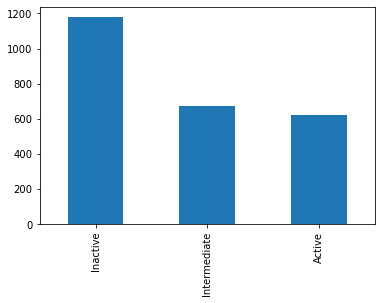

In [31]:
print(df_fp.activity_type.value_counts())
df_fp.activity_type.value_counts().plot.bar(x='activity_type')

Now we filter the data removing those that remained as *Intermediate*

# ligands (active/inactive): 1801
Inactive    1178
Active       623
Name: activity_type, dtype: int64


,molecule_chembl_id,morgan2_c,pchembl_value,activity_type
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",10.89,Active
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.00,Active
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",9.85,Active
4,CHEMBL4063206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9.70,Active


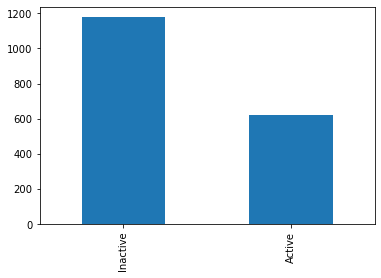

In [32]:
bd = df_fp[df_fp['activity_type'] != 'Intermediate'].copy()
bd.activity_type.value_counts().plot.bar(x='activity_type')
print(f'# ligands (active/inactive): {len(bd)}')
print(bd.activity_type.value_counts())
bd.head()

Since it is a binary classification, we must assign a label: (Inactive:0 / Active:1)

In [33]:
bd['activity'] = 0
bd.loc[bd[bd.activity_type == 'Active'].index, 'activity'] = 1.0
bd.drop(['activity_type', 'pchembl_value'], axis=1, inplace=True)
bd.head()

,molecule_chembl_id,morgan2_c,activity
0,CHEMBL2386094,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0
1,CHEMBL3895998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
2,CHEMBL4084855,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
3,CHEMBL564450,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.0
4,CHEMBL4063206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0


We already have the characteristics (morgan2_c) and labels (activity) to be able to train the model

# Machine Learning

## Model training

We are going to train a model that classifies ligands knowing the fingerprint. The goal is to test the model's ability to predict data that has never been seen before, to detect problems known as overfitting, and to assess the generalizability of the model.

### Random Forest
Usually, the first step is to **split** the data set, one part for training (70%) and the other part for validation (30%).

In [34]:
from sklearn.model_selection import train_test_split
fp_df_train, fp_df_valid = train_test_split(bd, test_size=0.3, random_state=142857,
                                             shuffle=True, stratify=bd['activity'])
fp_df_train.reset_index(drop=True, inplace=True)
fp_df_valid.reset_index(drop=True, inplace=True)
print(f'# training data: {len(fp_df_train)},'
       f'\n# validation data: {len(fp_df_valid)}')

# training data: 1260,
# validation data: 541


Now, for each set we are going to separate the characteristics (the fingerprint) and the label

In [35]:
X_train, y_train = fp_df_train.morgan2_c, fp_df_train.activity
X_valid, y_valid = fp_df_valid.morgan2_c, fp_df_valid.activity
# The array of features should be converted to a list of items
X_train, X_valid = X_train.tolist(), X_valid.tolist()

We choose the estimator of [Random Fores classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to train the model, the model must be instantiated and built

In [36]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

## Validation
### Accuracy Score
There are several metrics to measure the ability of the model to make predictions, let's see an example using the metric [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html?highlight =accuracy_score#sklearn.metrics.accuracy_score). For which you must first classify (*predict*) the data and then compare them with the true labels, we will do this with both the **training set** and the **validation set**:

In [37]:
from sklearn.metrics import accuracy_score
# Prediction training set
y_train_pred = model.predict(X_train)
# prediction set validation
y_valid_pre = model.predict(X_valid)

# Punctuation
acc_train = accuracy_score(y_train, y_train_pred)
acc_valid = accuracy_score(y_valid, y_valid_pre)
print(f'Accuracy training set: {acc_train:.4f} ({acc_train:.2%})\n'
       f'Accuracy validation set: {acc_valid:.4f} ({acc_valid:.2%})')

Accuracy training set: 1.0000 (100.00%)
Accuracy validation set: 0.8799 (87.99%)


The *accuracy** of the training set is 100%, indicating a case of *Overfitting*, possibly adjusting the parameters of the classification model or even using another model.

### Confusion Matrix
With this matrix you can compare the true labels versus the predictions, [here](https://en.wikipedia.org/wiki/Confusion_matrix) you can see more information.

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_valid, y_valid_pre, colorbar=False,  cmap=plt.cm.Blues)

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

You can work with the normalized data to see it as a percentage

In [39]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_valid_pre, colorbar=False,
                                        cmap=plt.cm.Blues, normalize='true')

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

### ROC curve
The ROC curve (ROC curve, Receiver Operating Characteristic) is a graphical representation of the sensitivity versus the specificity for a binary classifier system as the discrimination threshold is varied, it is usually used to represent how good the model is, let's see how you can build one:

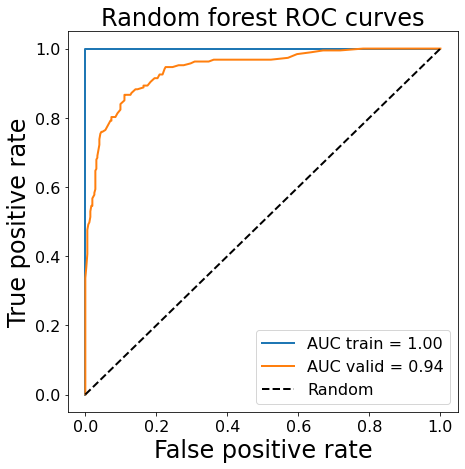

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib as mpl
import matplotlib.pyplot as plt

# Probability of predictions
pred_prob_train = model.predict_proba(X_train)[:, 1]
pred_prob_valid = model.predict_proba(X_valid)[:, 1]

# false positive rates / true prfositive rates - training
fpr_train, tpr_train, _ = roc_curve(y_train, pred_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)
# false positive rates / true positive rates - validation
fpr_valid, tpr_valid, _ = roc_curve(y_valid, pred_prob_valid)
roc_auc_valid = auc(fpr_valid, tpr_valid)

plt.figure(figsize=(7, 7))
plt.plot(fpr_train, tpr_train, label=f'AUC train = {roc_auc_train:.2f}', lw=2)
plt.plot(fpr_valid, tpr_valid, label=f'AUC valid = {roc_auc_valid:.2f}', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black") # Random curve

plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title('Random forest ROC curves', size=24)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16)

### K-fold (cross validation)

We are going to divide the data into 5 sets, each one of them will train the algorithm and measure its predictive capacity, then the data from the five models will be contrasted to validate if the trained model works or not.

In [41]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

n_folds = 5
# empty result vector
results = []
# Shuffle the indices for k-fold cross-validation
kf = KFold(n_splits=n_folds, shuffle=True)
# Labels initialized with -1 for each data point
labels = -1 * np.ones(len(bd))
# instance model
model = RandomForestClassifier()

for train_index, test_index in kf.split(bd):
     # Training
     # Converts the bit vector and the label to a list
     train_x = bd.iloc[train_index].morgan2_c.tolist()
     train_y = bd.iloc[train_index].activity.tolist()

     # fit the model
     model.fit(train_x, train_y)

     # Evidence
     # Converts the bit vector and the label to a list
     test_x = bd.iloc[test_index].morgan2_c.tolist()
     test_y = bd.iloc[test_index].activity.tolist()
     # Predict on test set
     prediction_prob = model.predict_proba(test_x)[:, 1]
     # Save the predicted label of each fold
     labels[test_index] = model.predict(test_x)

     # performance
     # Get fpr, tpr and roc_auc for each fold
     fpr_l, tpr_l, _ = roc_curve(test_y, prediction_prob)
     roc_auc_l = auc(fpr_l, tpr_l)
     # Add to results
     results.append((fpr_l, tpr_l, roc_auc_l))
# Get overall accuracy, sensitivity, specificity
y = bd.activity.tolist()
acc = accuracy_score(y, labels)
sens = recall_score(y, labels)
spec = (acc * len(y) - sens * sum(y)) / (len(y) - sum(y))

In [42]:
plt.figure(figsize=(7, 7))
cmap = mpl.colormaps['Blues']
colors = [cmap(i) for i in np.linspace(0.1, 1.0, n_folds)]

for i, (fpr_l, tpr_l, roc_auc_l) in enumerate(results):
    plt.plot(fpr_l, tpr_l, label='AUC CV$_{0}$ = {1:0.2f}'.format(str(i),roc_auc_l), lw=2, color=colors[i])
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve
plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title(f'Random forest ROC curves', size=24)
plt.tick_params(labelsize=16)
plt.legend(fontsize=16)

plt.show()

AttributeError: module 'matplotlib' has no attribute 'colormaps'

<Figure size 504x504 with 0 Axes>

In [ ]:

# Calcule el AUC media e imprima
m_auc = np.mean([elem[2] for elem in results])
print(f'Mean AUC: {m_auc:.3f}')

# Mostrar precisión general, sensibilidad, especificidad
print(f'Sensitivity: {sens:.3f}\nAccuracy: {acc:.3f}\nSpecificity: {spec:.3f}')